# Testing new utility function for MPO

Data imports.

In [2]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Instantiate designer.

In [3]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Instantiate Oracles.

In [86]:
from dgym.envs.utility import PenaltyUtilityFunction

docking_utility = PenaltyUtilityFunction(
    ideal=(8, float('inf')),
    acceptable=(7.5, float('inf'))
)

In [136]:
docking_utility([7.95, 10])

array([0.1, 0. ])

<Axes: >

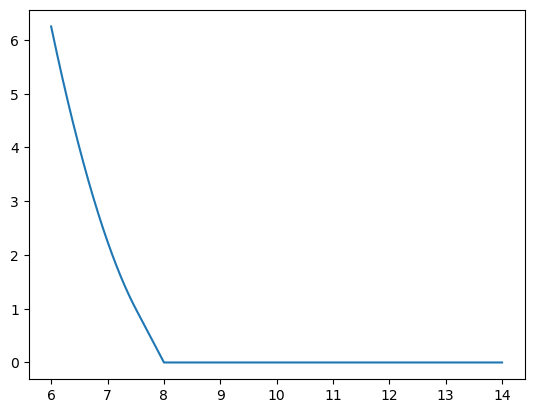

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

scores = np.linspace(6, 14, 1_000)
utility = docking_utility(scores)
sns.lineplot(x=scores, y=utility)

In [18]:
%%time
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

np.random.seed(42)  # For reproducible results
solutions = np.random.rand(1_000, 3)  # 10 solutions in a 3-dimensional space
objectives = np.zeros((1_000, 3))  # Placeholder for objectives

# Define the objective functions (hypothetical)
def f1(x):
    return (x[0]-0.5)**2  # Objective 1

def f2(x):
    return (x[1]-0.5)**2  # Objective 2

def f3(x):
    return (x[2]-0.5)**2  # Objective 3

# Apply objectives to each solution
for i, sol in enumerate(solutions):
    objectives[i, 0] = f1(sol)
    objectives[i, 1] = f2(sol)
    objectives[i, 2] = f3(sol)

# Perform non-dominated sorting
nds = NonDominatedSorting().do(objectives, only_non_dominated_front=False)

CPU times: user 5.11 ms, sys: 0 ns, total: 5.11 ms
Wall time: 5.09 ms


In [19]:
nds

[array([ 47,  77,  91, 113, 116, 216, 230, 247, 278, 287, 379, 426, 443,
        483, 527, 567, 662, 695, 770, 804, 819, 831, 853, 882, 922, 958,
        982]),
 array([141, 326, 371, 625, 707, 896, 237, 422, 502, 716, 861, 876,  43,
        962,  34, 554, 865, 328, 562, 577, 648,  49, 646,  13,  31, 828,
        938, 989,  62, 100, 202, 586, 680, 683, 813, 837, 924, 477, 642,
        757]),
 array([134, 264, 377, 207, 304, 352, 438, 553, 787, 190, 262, 419, 459,
        515, 589, 687, 694, 244, 194, 759,   9, 336, 575, 150, 188, 279,
        354, 652, 685, 224, 547, 671, 210, 282, 563,  95, 473, 581, 228,
        450, 184, 233, 401, 500, 597, 752, 767, 864,  45, 464, 537, 726,
        898, 943]),
 array([624, 159, 246, 274, 318, 644, 762, 657, 903, 909, 639, 552, 594,
        883, 211, 333, 732,  70, 102, 389, 508, 893, 868, 715, 931, 997,
        163, 457, 585, 669, 860, 403, 643,  57, 756,  32, 175, 323, 755,
        839, 936, 138, 364, 529, 955, 677, 198, 260, 626, 719, 965]),
 arr

In [1]:
import numpy as np
from pymoo.factory import get_problem
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Define a hypothetical set of solutions and their objectives
# Let's say we have 10 solutions (for simplicity) and 3 objectives
np.random.seed(42)  # For reproducible results
solutions = np.random.rand(10, 3)  # 10 solutions in a 3-dimensional space
objectives = np.zeros((10, 3))  # Placeholder for objectives

# Define the objective functions (hypothetical)
def f1(x):
    return (x[0]-0.5)**2  # Objective 1

def f2(x):
    return (x[1]-0.5)**2  # Objective 2

def f3(x):
    return (x[2]-0.5)**2  # Objective 3

# Apply objectives to each solution
for i, sol in enumerate(solutions):
    objectives[i, 0] = f1(sol)
    objectives[i, 1] = f2(sol)
    objectives[i, 2] = f3(sol)

# Perform non-dominated sorting
nds = NonDominatedSorting().do(objectives, only_non_dominated_front=True)

# Extract non-dominated solutions
non_dominated_solutions = solutions[nds]

print("Non-dominated Solutions:")
print(non_dominated_solutions)

ModuleNotFoundError: No module named 'pymoo.factory'